# Density at 150 pc (NFW) - pericenter relation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import h5py
import os

from density_profile_fit_utils import fit_nfw_model, fit_core_nfw_model, fit_isothermal_model
from density_profile_utils import calculate_rho_s, calculate_r_s, calculate_M200, calculate_R200, NFW_profile, mass, rho_mean, calculate_error_NFW_rho
from density_pericenter_fit_utils import log_model, run_best_fit_for_sim, run_best_fit_for_sim_with_mcmc

from scipy.optimize import curve_fit

plt.style.use("pltstyle.mplstyle")
cmap = matplotlib.cm.RdYlBu

## Observational data

In [2]:
GAIA_PATH = "../data/Gaia/"
Kaplinghat_data = pd.read_csv(GAIA_PATH+"Kaplinghat_2019.csv").to_numpy()

dSph = Kaplinghat_data[:,0]
dSph = dSph[::2]

num_satellites = len(dSph)

In [3]:
# We remove CVnI
num_satellites = 8
dSph = dSph[:-1]

r_p_Isolated = np.zeros((3,num_satellites)) # Reading pericenter assuming isolated MW
r_p_LMC = np.zeros((3,num_satellites))      # Reading pericenter assuming MW perturbed by LMC
rho_150pc_K19 = np.zeros((3,num_satellites)) # Reading Kaplinghat+ 2019 determination under NFW


for i, dSphi in enumerate(dSph):
    filename = "Cardona_2023_"+dSphi+".csv"
    data = pd.read_csv(GAIA_PATH + filename).to_numpy()
    r_p_Isolated[0,i] = data[2,0] # Pericenter [kpc]
    r_p_Isolated[1,i] = data[2,1] # (Error) Pericenter [kpc]
    r_p_Isolated[2,i] = data[2,2] # (Error) Pericenter [kpc]
    r_p_LMC[0,i] = data[3,0] # Pericenter [kpc]
    r_p_LMC[1,i] = data[3,1] # Pericenter [kpc]
    r_p_LMC[2,i] = data[3,2] # Pericenter [kpc]
    rho_150pc_K19[0,i] = data[8,0] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[1,i] = data[8,1] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[2,i] = data[8,2] * 1e7 # Central density [Msun/kpc^3]

In [4]:
# We do the fitting for observations

popt_p_Isolated, pcov = curve_fit(log_model, np.log10(r_p_Isolated[0,:]), np.log10(rho_150pc_K19[0,:]/1e7))
perr_p_Isolated = np.sqrt(np.diag(pcov))
print(popt_p_Isolated, perr_p_Isolated)
popt_p_LMC, pcov = curve_fit(log_model, np.log10(r_p_LMC[0,:]), np.log10(rho_150pc_K19[0,:]/1e7))
perr_p_LMC = np.sqrt(np.diag(pcov))
print(popt_p_LMC, perr_p_LMC)

[ 2.30112007 -0.66128207] [0.58704218 0.34001611]
[ 1.51969014 -0.19019314] [0.84792992 0.4520326 ]


(10.0, 500.0, 5000000.0, 1000000000.0)

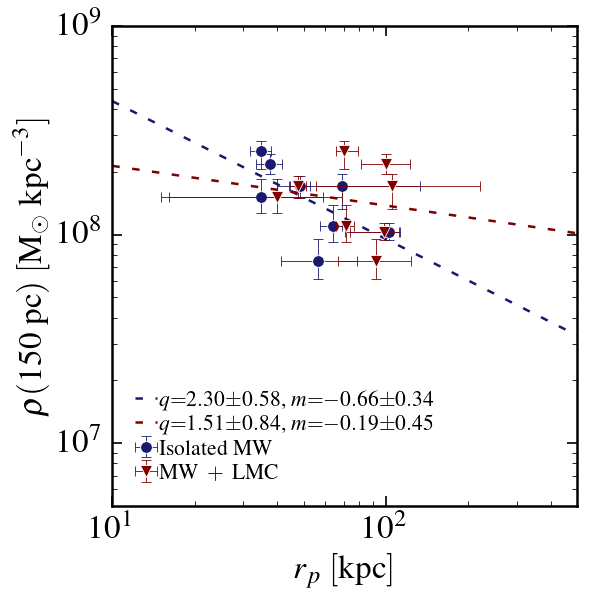

In [59]:
def plot_obs(axs):

    # Data points                 
    p1 = axs.errorbar(r_p_Isolated[0,:], rho_150pc_K19[0,:], xerr=r_p_Isolated[1:,:], yerr=rho_150pc_K19[1:,:],
                      marker='o', markersize=7, markeredgecolor="white", ls='none', lw=0.5, c='midnightblue',
                      label=r'$\mathrm{Isolated\ MW}$')
    p2 = axs.errorbar(r_p_LMC[0,:], rho_150pc_K19[0,:], xerr=r_p_LMC[1:,:], yerr=rho_150pc_K19[1:,:],
                      marker='v', markersize=7, markeredgecolor="white", ls='none', lw=0.5, c='maroon',
                      label=r'$\mathrm{MW\ +\ LMC}$')

    # Include the fit from Cardona+ 2023
    xrange = np.arange(1, 3.2, 0.2)
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, *popt_p_Isolated), '--', 
             lw=1.5, color=p1[0].get_color(), label=r'$q{=}2.30{\pm}0.58$, $m{=}{-}0.66{\pm}0.34$')
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, *popt_p_LMC), '--', 
             lw=1.5, color=p2[0].get_color(), label=r'$q{=}1.51{\pm}0.84$, $m{=}{-}0.19{\pm}0.45$')
    
    axs.legend(loc=[0.03, 0.03], labelspacing=0.2, handlelength=1, handletextpad=0.1, frameon=False, fontsize=13, ncol=1, numpoints=1)
    axs.set_yscale('log')
    axs.set_xscale('log')
    
    
fig, axs = plt.subplots(1, 1, figsize=(5, 5), dpi=120)
plot_obs(axs)
axs.set_xlabel(r'$r_{{p}}\ [\mathrm{kpc}]$')
axs.set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^{-3}]$')
axs.axis([10, 500, 5e6, 1e9])

## Simulations analysis

In [17]:
#DATA_PATH = "../data/TangoSIDM/"
DATA_PATH = "/Users/cc276407/Simulation_data/snellius/TangoSatellites/updated2/"

IDs = {
    "SigmaConstant00": "CDM",
    "SigmaConstant01": "SigmaConstant01",
#    "SigmaConstant10": "SigmaConstant10", # I will not include this sim. since its cross section is already ruled out by galaxy clusters
    "SigmaVelDep20Anisotropic": "SigmaVel20",
    "SigmaVelDep60Anisotropic": "SigmaVel60", 
    "SigmaVelDep100Anisotropic": "SigmaVel100",
}

### Fit each MW system in each box

In [18]:
MAX_SATELLITES = None

CDM q m
1.3989734416720834 -0.08939467239562858
SigmaConstant01 q m
1.1806766997766955 -0.049101955515512184
SigmaVel20 q m
1.2465580566042254 -0.07028254117391547
SigmaVel60 q m
1.1716809271937279 -0.02496439528199086
SigmaVel100 q m
1.5649612280975345 -0.22455317788748105


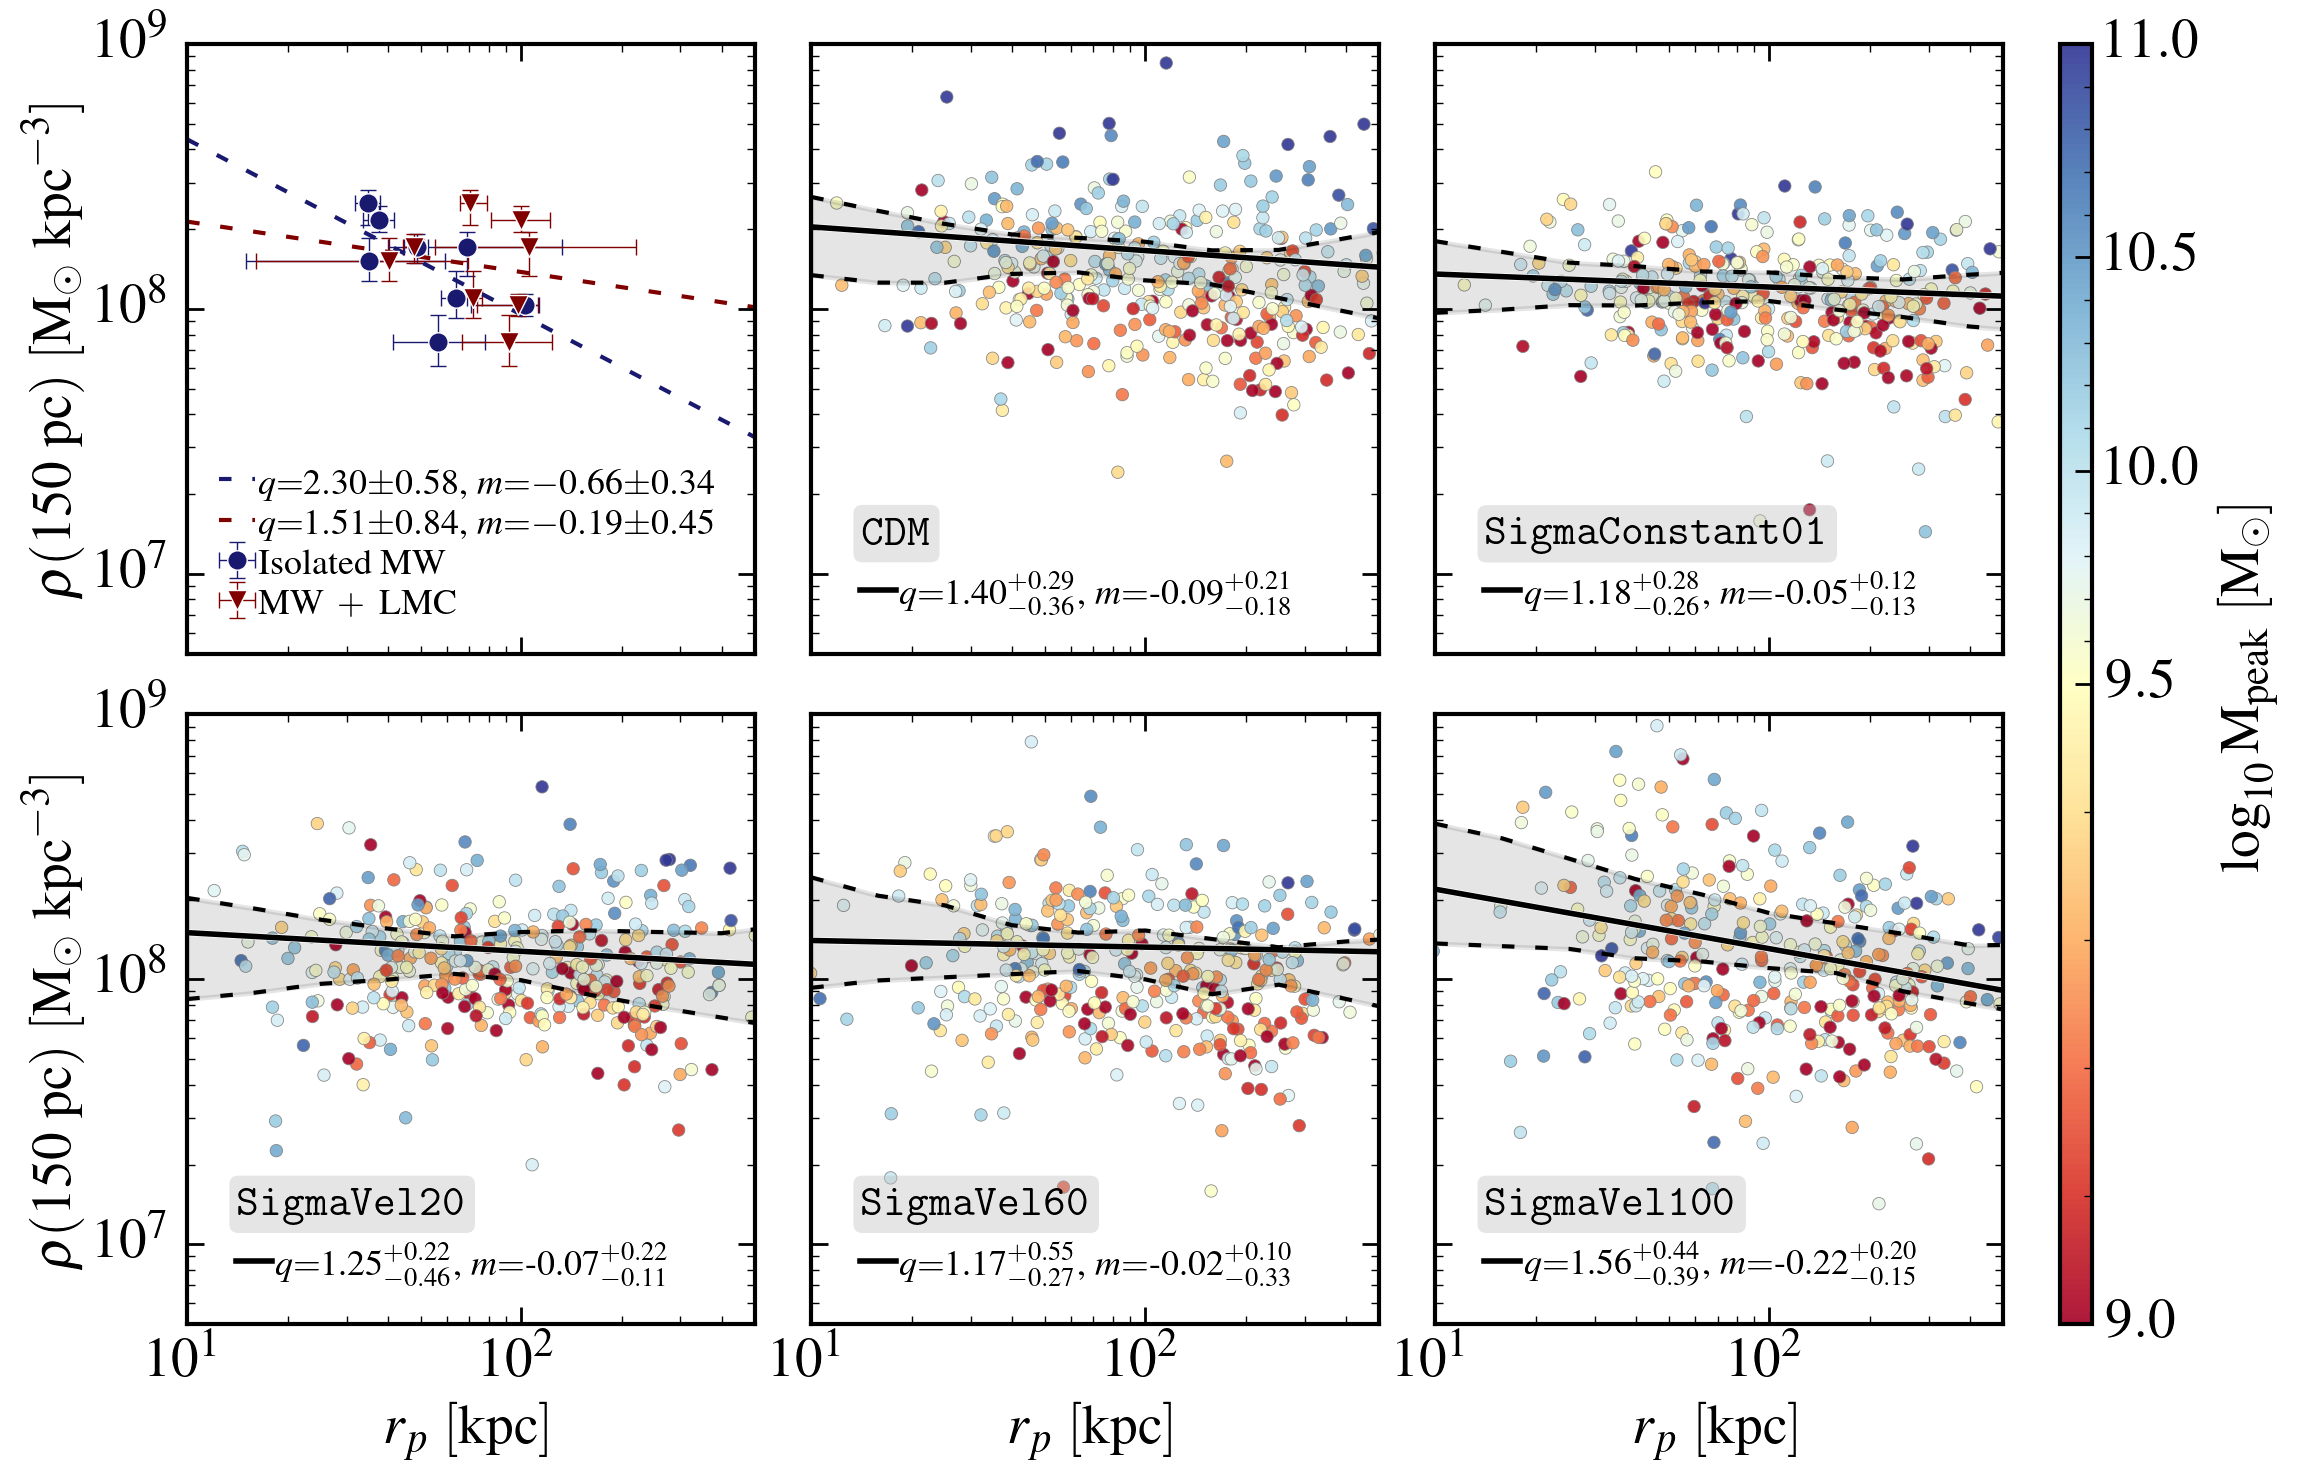

In [51]:
normalize = matplotlib.colors.TwoSlopeNorm(vmin=9, vcenter=9.5, vmax=11)
fig, all_axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(13, 8), dpi=200, facecolor='white')
all_axs = all_axs.flatten() 

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    axs = all_axs[i+1]
        
    q = []
    m = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M = [], [], []
            counter = 0
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:MAX_SATELLITES]:
                if np.log10(file[str(subhalo_idx)]['tree_data']['bound_mass_dm'][0]) > 9: # MINIMUM satellite mass = 10^9
                    data_subhalo = file[f'{subhalo_idx}']

                    # Get pericenter
                    _rp = data_subhalo["tree_data"]["pericenter"][1]
                    _rp = _rp[0] if _rp.shape==(1,) else _rp
                    rp = np.append(rp, _rp)

                    nfw_fit = data_subhalo['halo_data']['nfw_fit']
                    r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                    rho_s = 10**log10_rho_s
                    _rho_150 = 10**fit_nfw_model(np.array([0.15]), r_s, log10_rho_s)
                    rho150 = np.append(rho150, _rho_150[0])
        
                    # sigma_rho_s = sigma_log10_rho_s * np.log(10) * rho_s
                    # rho = NFW_profile(r_range, rho_s, r_s)
                    # mass_within_r = mass(rho, r_range)
                    # rho_within_r = rho_mean(mass_within_r, r_range)
                    # R200 = calculate_R200(rho_within_r, r_range)
                    # _M = calculate_M200(R200)
                    # M = np.append(M, _M)
                    
                    z_accr_type_idx, accretion = data_subhalo['tree_data']['accretion']
                    mass_peak = data_subhalo['tree_data']['bound_mass_dm'][int(z_accr_type_idx)]                
                    M = np.append(M, mass_peak)
                    
                    counter+=1

            if counter<8: continue # Fit only systems with at least 8 satellites        
            im = axs.scatter(rp, rho150, c=np.log10(M), cmap=cmap, marker='o', edgecolors='grey',
                             lw=0.3, norm=normalize, alpha=0.9)

            # Fit
            _q, _m = run_best_fit_for_sim(rp, rho150)
            q = np.append(q, _q)
            m = np.append(m, _m)
    
    print(id_name,'q','m')
    xrange = np.arange(1, 3.2, 0.2)
    num_range = len(xrange)
    yrange = np.ones((2,num_range))
    print(np.median(q), np.median(m))

    errq2 = np.median(q)-np.percentile(q,16)
    errq1 = np.percentile(q,84)-np.median(q)
    errm2 = np.median(m)-np.percentile(m,16)
    errm1 = np.percentile(m,84)-np.median(m)
    label='$q{=}$%.2f'%np.median(q)
    label+='$^{+%.2f}'%errq1+'_{-%.2f}$'%errq2
    label+=', $m{=}$%.2f'%np.median(m)
    label+='$^{+%.2f}'%errm1+'_{-%.2f}$'%errm2

    
    for k in range(num_range):
        yrange[0, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], q, m), 16)
        yrange[1, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], q, m), 84)

    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, np.median(q), np.median(m)), '-', lw=2.5, color='white')
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, np.median(q), np.median(m)), 
             '-', lw=2., color='black',label=label)
    axs.fill_between(10 ** xrange, yrange[0,:], yrange[1,:], color='black', alpha=0.1)
    axs.plot(10 ** xrange, yrange[0,:], '--', color='black')
    axs.plot(10 ** xrange, yrange[1,:], '--', color='black')

    axs.text(0.09, 0.18,  fr'$\texttt{{{id_name}}}$', color='black', transform=axs.transAxes,
                bbox=dict(facecolor='silver', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2'), zorder=1000) #, horizontalalignment='right')
        
    axs.axis([10, 500, 5e6, 1e9])
    axs.set_xscale('log')
    axs.set_yscale('log')
    axs.legend(loc=[0.06, 0.04], labelspacing=0.2, handlelength=1, handletextpad=0.1, frameon=False, fontsize=13, ncol=1, numpoints=1)
    
    if i >= 3-1:
        axs.set_xlabel(r'$r_{{p}}\ [\mathrm{kpc}]$')
    else:
        axs.get_xaxis().set_ticklabels([])
        
    if i==3-1:
        axs.set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^{-3}]$')
    else:
        axs.get_yaxis().set_ticklabels([])

    ####
    file.close()

####
axs = all_axs[0]
plot_obs(axs)
axs.set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^{-3}]$')
plt.subplots_adjust(hspace=0.1, wspace=0.1, right=.86)

####
# Let's add a colorbar
cbar = plt.colorbar(im, ax=all_axs.ravel().tolist(), label='$\log_{10}\mathrm{M_{peak}}$ $\mathrm{[M_\odot]}$',
                     aspect=40, fraction=0.02, pad=0.03)
cbar.ax.set_yticks([9, 9.5, 10, 10.5, 11]) 

####
plt.savefig(f'figures/Density_pericenter_fit_system_mpeak_best_{MAX_SATELLITES}.png',dpi=300)#, transparent=True)
plt.show()


#### MCMC

In [ ]:
filename = f"./outputs/fit_NFW_{MAX_SATELLITES}.npy" if MAX_SATELLITES is not None else "./outputs/fit_NFW.npy"

if os.path.isfile(filename):
    run_fit = False
    q_save, m_save = np.load(filename, allow_pickle=True)
else:
    run_fit = True
    q_save, m_save = [], []
    
print(run_fit)

In [ ]:

cmap = matplotlib.cm.RdYlBu
normalize = matplotlib.colors.TwoSlopeNorm(vmin=9, vcenter=9.5, vmax=11)          
                                
fig, all_axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(13, 8), dpi=200, facecolor='white')
all_axs = all_axs.flatten()

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    axs = all_axs[i+1]

    qs = []
    ms = []
    
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M = [], [], []
            counter = 0
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:MAX_SATELLITES]:
                if np.log10(file[str(subhalo_idx)]['tree_data']['bound_mass_dm'][0]) > 9: # MINIMUM satellite mass = 10^9
                    data_subhalo = file[f'{subhalo_idx}']
                    # Get pericenter
                    _rp = data_subhalo["tree_data"]["pericenter"][1]
                    _rp = _rp[0] if _rp.shape==(1,) else _rp
                    rp = np.append(rp, _rp)

                    nfw_fit = data_subhalo['halo_data']['nfw_fit']
                    r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                    rho_s = 10**log10_rho_s
                    _rho_150 = 10**fit_nfw_model(np.array([0.15]), r_s, log10_rho_s)
                    rho150 = np.append(rho150, _rho_150[0])
        
                    # sigma_rho_s = sigma_log10_rho_s * np.log(10) * rho_s
                    # rho = NFW_profile(r_range, rho_s, r_s)
                    # mass_within_r = mass(rho, r_range)
                    # rho_within_r = rho_mean(mass_within_r, r_range)
                    # R200 = calculate_R200(rho_within_r, r_range)
                    # _M = calculate_M200(R200)
                    # M = np.append(M, _M)
                    
                    z_accr_type_idx, accretion = data_subhalo['tree_data']['accretion']
                    mass_peak = data_subhalo['tree_data']['bound_mass_dm'][int(z_accr_type_idx)]                
                    M = np.append(M, mass_peak)

                    counter+=1
                    
            if counter<8: continue# Fit only systems with at least 8 satellites
            im = axs.scatter(rp, rho150, c=np.log10(M), cmap=cmap, marker='o', 
                                lw=0, norm=normalize, alpha=0.8)
            # Fit
            if run_fit:
                samples= run_best_fit_for_sim_with_mcmc(rp, rho150)
                _q, _m = np.median(samples[:, 0]), np.median(samples[:, 1])
                qs = np.append(qs, _q)
                ms = np.append(ms, _m)
                print(ms)
                

    if run_fit:
        q_save.append(qs)
        m_save.append(ms)
    else:
        qs = q_save[i]
        ms = m_save[i]

    print(id_name)
    xrange = np.arange(1, 3.2, 0.2)
    num_range = len(xrange)
    yrange = np.ones((2,num_range))
    q = np.median(qs)
    m = np.median(ms)
    print(q, m)
    
    for k in range(num_range):
        yrange[0, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], qs, ms), 16)
        yrange[1, k] = np.percentile(1e7 * 10 ** log_model(xrange[k], qs, ms), 84)
    
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange, q, m), '-', lw=2.5, color='white')
    axs.plot(10 ** xrange, 1e7 * 10 ** log_model(xrange,  q, m), '-', lw=2., color='black')
    axs.fill_between(10 ** xrange, yrange[0,:], yrange[1,:], color='black', alpha=0.1)
    axs.plot(10 ** xrange, yrange[0,:], '--', color='black')
    axs.plot(10 ** xrange, yrange[1,:], '--', color='black')

    axs.text(0.1, 0.1,  fr'$\texttt{{{id_name}}}$', color='black', transform=axs.transAxes,
                bbox=dict(facecolor='silver', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2'), zorder=1000) #, horizontalalignment='right')
        
    axs.axis([10, 500, 5e6, 1e9])
    axs.set_xscale('log')
    axs.set_yscale('log')
    
    if i >= 3-1:
        axs.set_xlabel(r'$r_{{p}}\ [\mathrm{kpc}]$')
    else:
        axs.get_xaxis().set_ticklabels([])
        
    if (i==3-1):
        axs.set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^{-3}]$')
    else:
        axs.get_yaxis().set_ticklabels([])


    ####
    file.close()
    # break
    

# Save fit
if run_fit:
    q_save = np.array(q_save, dtype=object)
    m_save = np.array(m_save, dtype=object)
    np.save(filename, (q_save, m_save))

####
axs = all_axs[0]
plot_obs(axs)
axs.set_ylabel(r'$\rho(150\ \mathrm{pc})\ [\mathrm{M}_\odot \ \mathrm{kpc}^{-3}]$')
plt.subplots_adjust(hspace=0.1, wspace=0.1, right=.86)

####
# Let's add a colorbar
cbar = plt.colorbar(im, ax=all_axs.ravel().tolist(), label='$\log_{10}\mathrm{M_{peak}}$ $\mathrm{[M_\odot]}$',
                    aspect=40, fraction=0.02, pad=0.03)
cbar.ax.set_yticks([9, 9.5, 10, 10.5, 11]) 


plt.savefig(f'figures/Density_pericenter_fit_system_mpeak_mcmc_{MAX_SATELLITES}.png', dpi=300, transparent=True)
plt.show()